In [1]:
import os
import cv2
import itertools
import multiprocessing
import concurrent.futures
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import Xception
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, Dropout, GlobalAveragePooling2D
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection  import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from keras.models import load_model
from keras.losses import CategoricalCrossentropy
from keras.losses import SparseCategoricalCrossentropy

In [19]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [2]:
path = '/ISIC_datasets/ISIC_2018/'

In [3]:
df = pd.read_csv(path + 'ISIC2018_Task3_Training_GroundTruth.csv')
df.head()

image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0

In [4]:
lesion_type_dict = {
    'MEL': 'Melanoma',
    'NV': 'Melanocytic nevus',
    'BCC': 'Basal cell carcinoma',
    'AKIEC': 'Actinic keratoses',
    'BKL': 'Benign keratosis',
    'DF': 'Dermatofibroma',
    'VASC': 'Vascular lesion',
}
classes = [value for key, value in lesion_type_dict.items()]
label_dict = dict([(column, i) for i, column in enumerate(df.columns[1:])])
lesion_tag_dict = dict([(i, column) for i, column in enumerate(df.columns[1:])])

In [6]:
CorrectedLabels = df[df.columns[1:]].to_numpy()
CorrectedLabels = np.argmax(CorrectedLabels, axis=1)
df['label'] = CorrectedLabels
df.head()

image  MEL   NV  BCC  AKIEC  BKL   DF  VASC  label
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0      1
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0      1
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0      1
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0      1
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0      0

In [7]:
df.drop(df.columns[1:8], axis=1, inplace=True)
df.head()

image  label
0  ISIC_0024306      1
1  ISIC_0024307      1
2  ISIC_0024308      1
3  ISIC_0024309      1
4  ISIC_0024310      0

In [8]:
df['disease'] = (df['label'].map(lesion_tag_dict.get)).map(lesion_type_dict.get)
df.head()

image  label            disease
0  ISIC_0024306      1  Melanocytic nevus
1  ISIC_0024307      1  Melanocytic nevus
2  ISIC_0024308      1  Melanocytic nevus
3  ISIC_0024309      1  Melanocytic nevus
4  ISIC_0024310      0           Melanoma

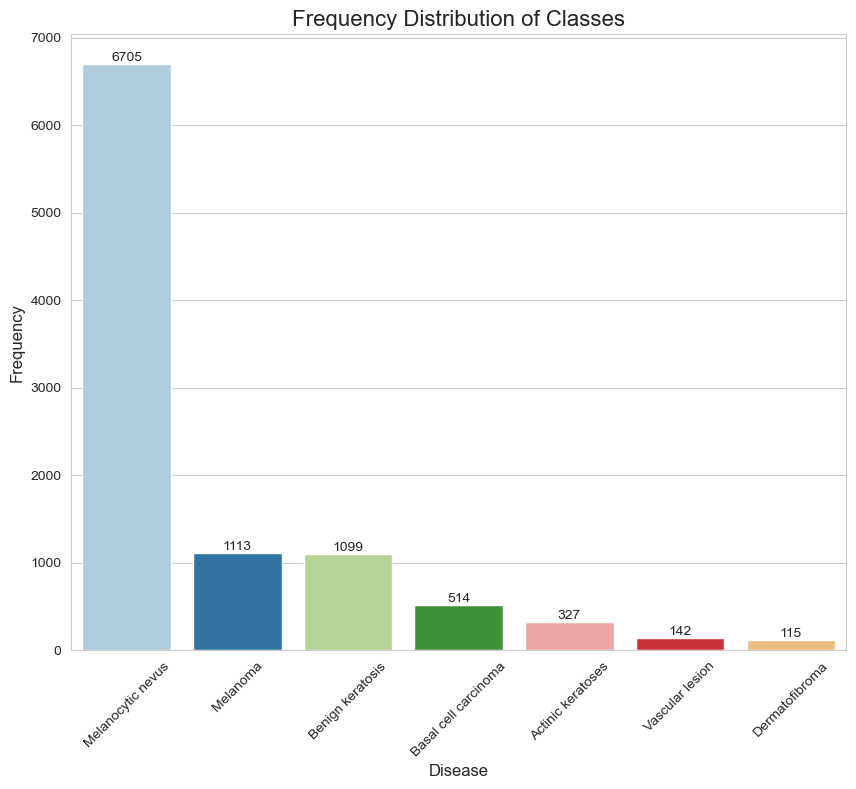

In [9]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(10,8))
ax = sns.countplot(x = 'disease', data = df, order = df['disease'].value_counts().index, palette='Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Frequency Distribution of Classes', size=16)
plt.xticks(rotation=45)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.show()

In [10]:
max_images_per_class = {
    'MEL': 2000,
    'NV': 2000,
    'BCC': 2000,
    'AKIEC': 1500,
    'BKL': 2000,
    'DF': 1000,
    'VASC': 1000,
}

In [11]:
images_to_be_cropped = df['disease'].value_counts()[0] - max_images_per_class['NV']
for index, row in df.iterrows():
    if  images_to_be_cropped > 0 and row['label'] == label_dict['NV']:
        images_to_be_cropped -= 1
        df.drop(index=index, inplace=True)

In [12]:
df['disease'].value_counts()

Melanocytic nevus       2000
Melanoma                1113
Benign keratosis        1099
Basal cell carcinoma     514
Actinic keratoses        327
Vascular lesion          142
Dermatofibroma           115
Name: disease, dtype: int64

In [13]:
image_size = 227
max_workers = multiprocessing.cpu_count()

def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((image_size,image_size)))

with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    image_arrays = list(executor.map(resize_image_array, (path + 'train/' + df['image'] + '.jpg').tolist()))

df['image_array'] = image_arrays
del image_arrays
df.head()

image  label           disease  \
4   ISIC_0024310      0          Melanoma   
6   ISIC_0024312      4  Benign keratosis   
7   ISIC_0024313      0          Melanoma   
9   ISIC_0024315      0          Melanoma   
12  ISIC_0024318      5    Dermatofibroma   

                                          image_array  
4   [[[71, 34, 38], [72, 32, 39], [71, 32, 38], [6...  
6   [[[171, 136, 168], [172, 137, 170], [173, 139,...  
7   [[[186, 140, 152], [186, 141, 155], [187, 143,...  
9   [[[148, 123, 142], [150, 129, 148], [149, 131,...  
12  [[[231, 177, 166], [230, 174, 166], [232, 176,...

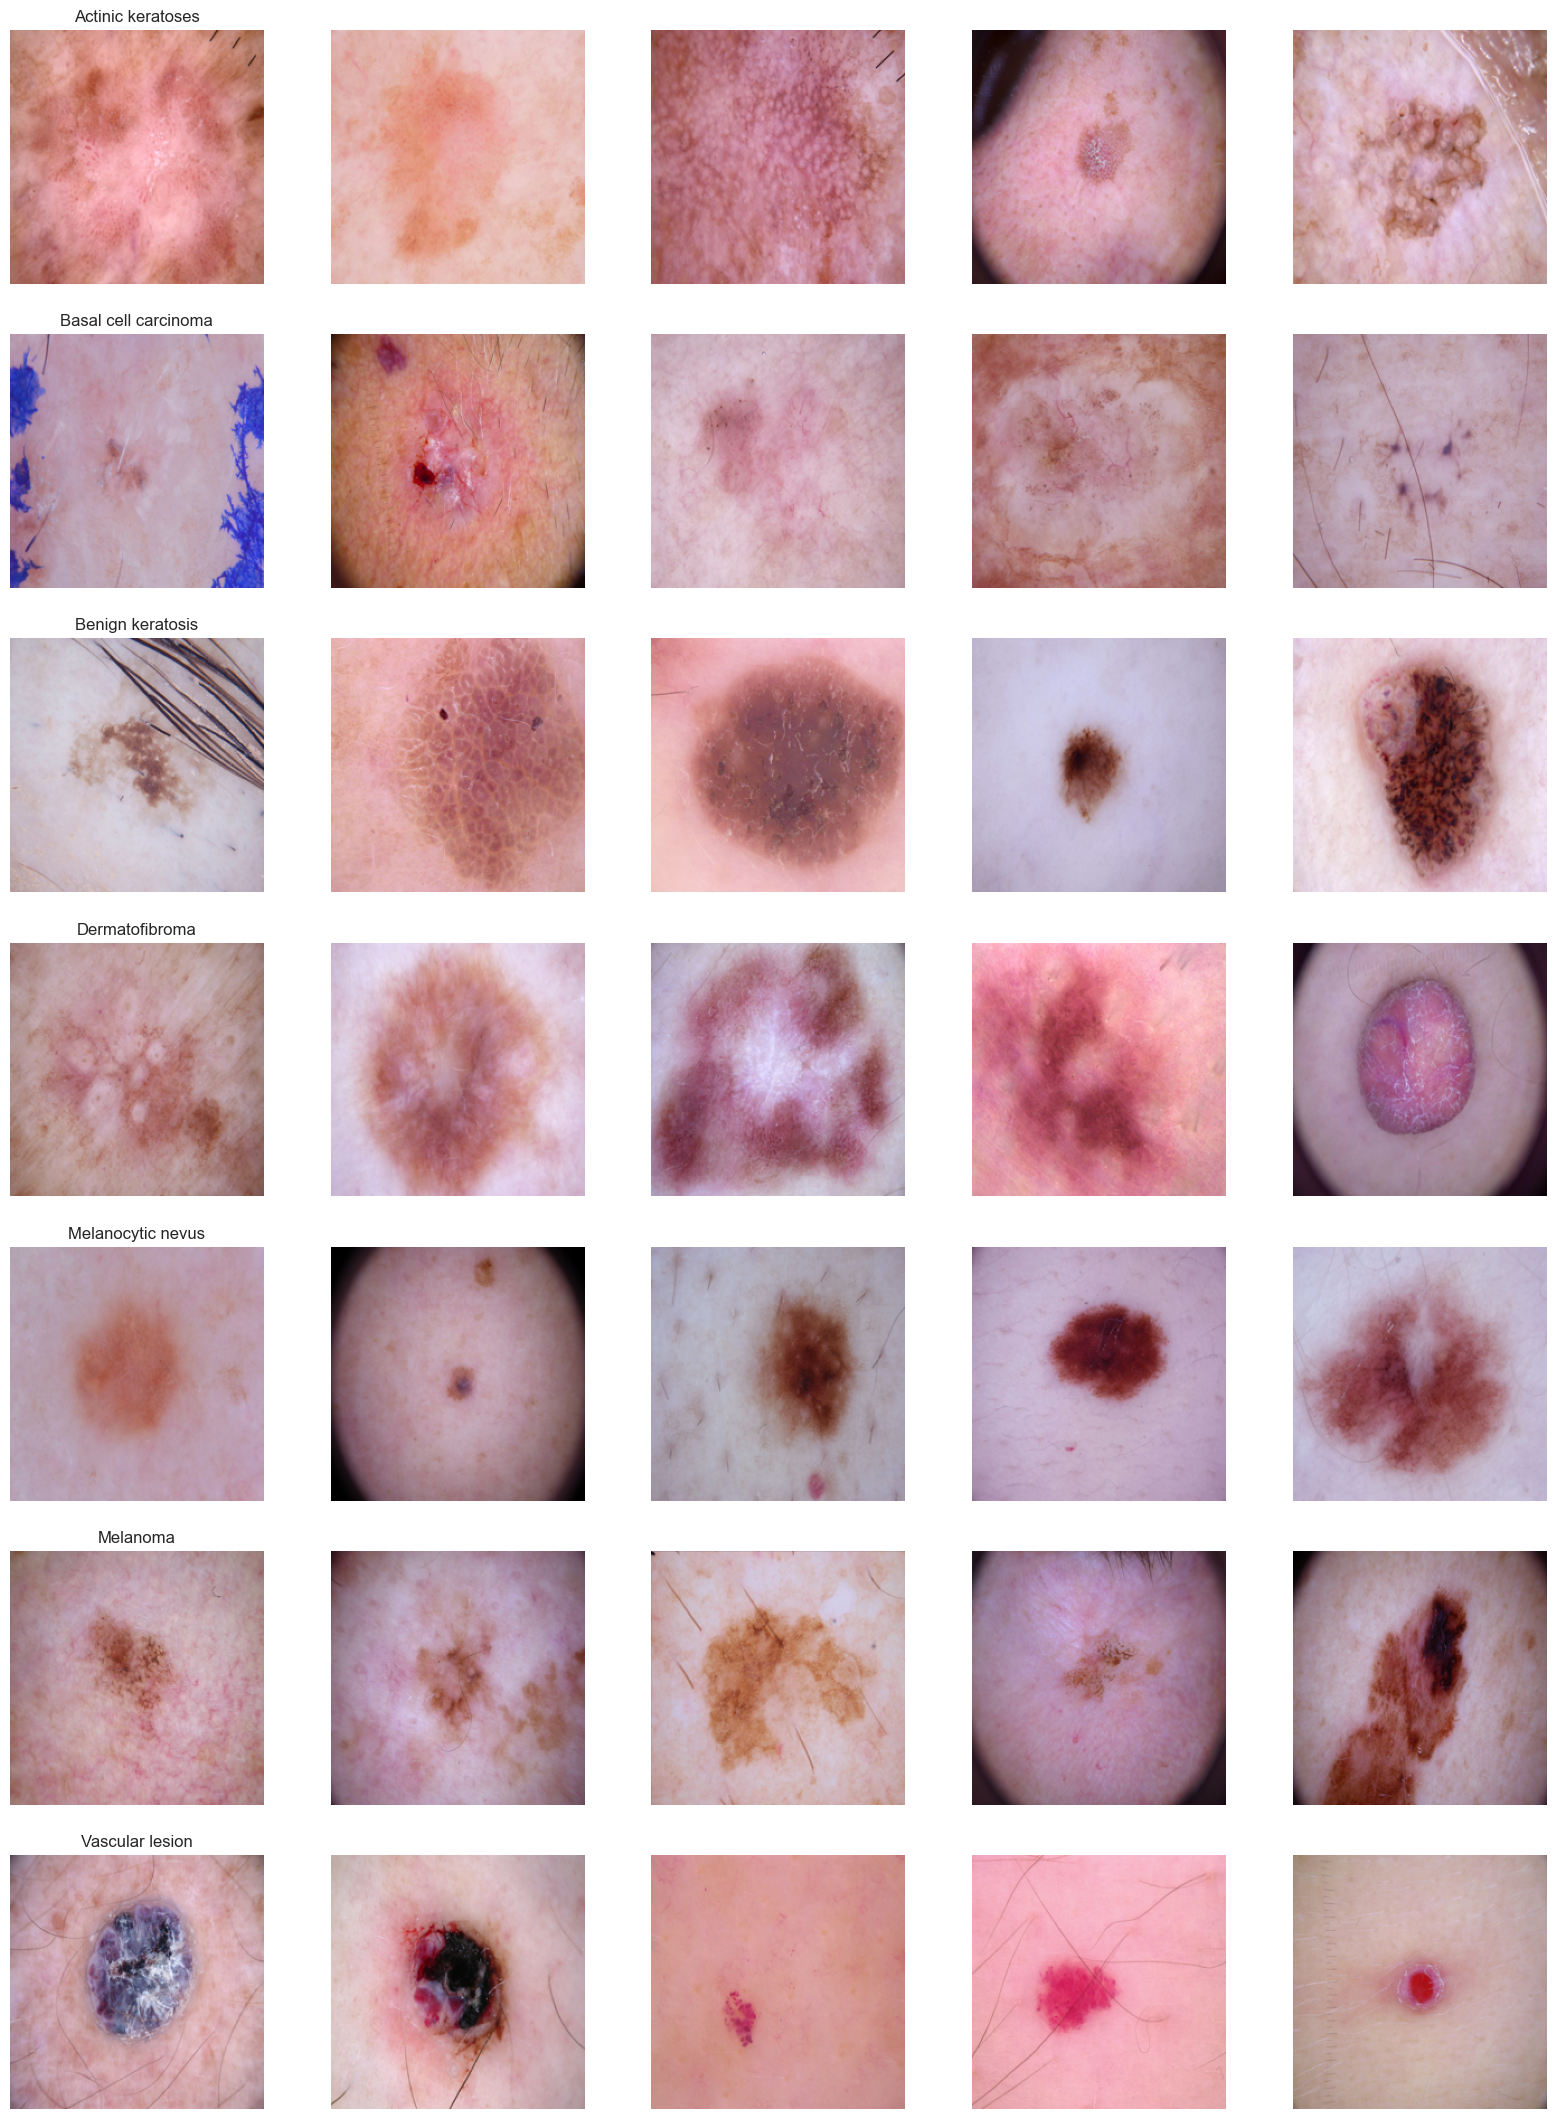

In [14]:
n_samples = 5
n_diseases = len(lesion_type_dict)
fig, m_axs = plt.subplots(n_diseases, n_samples, figsize = (4*n_samples, 3*9))
for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['disease']).groupby('disease')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image_array'])
        c_ax.axis('off')

In [15]:
datagen = ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip = True,
    fill_mode='nearest')

In [ ]:
augmented_df = pd.DataFrame(columns=['image', 'label', 'disease'])
array_of_images = []
for class_label in df['label'].unique():
    image_arrays = df.loc[df['label'] == class_label, 'image_array'].values
    num_images_needed = max_images_per_class[lesion_tag_dict[class_label]] - len(image_arrays)
    if num_images_needed > 0:
        np.random.seed(0)
        selected_images = np.random.choice(image_arrays, size=num_images_needed)
        print(selected_images.shape)
        print(type(selected_images))
        for image_array in selected_images:
            image_tensor = np.expand_dims(image_array, axis=0)
            augmented_images = datagen.flow(image_tensor, batch_size=1)       
            for i in range(augmented_images.n):
                augmented_image_array = augmented_images.next()[0].astype('uint8')
                array_of_images.append(augmented_image_array)
                new_row = {'image':None, 'label':class_label, 'disease':lesion_type_dict[lesion_tag_dict[class_label]]}
                augmented_df.loc[len(augmented_df)] = new_row
                
augmented_df['image_array'] = array_of_images
augmented_df.head()

(887,)
<class 'numpy.ndarray'>
(901,)
<class 'numpy.ndarray'>
(885,)
<class 'numpy.ndarray'>
(1173,)
<class 'numpy.ndarray'>
(1486,)
<class 'numpy.ndarray'>


In [ ]:
df = pd.concat([df, augmented_df])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
del augmented_df
df.head()

In [ ]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(10,8))
ax = sns.countplot(x = 'disease', data = df, order = df['disease'].value_counts().index, palette='Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.xticks(rotation=45)
plt.xlabel('Disease', size=12)
plt.ylabel('Number of Images', size=12)
plt.show()

In [ ]:
X = df.drop(columns=['image','label','disease'],axis=1)
X = X['image_array'].to_list()
y = df['label'].to_list()

In [ ]:
del df

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
del X
del y

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1111727505, random_state=42) # 80% 10% 10%

In [ ]:
x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [ ]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_val = x_val.astype('float32') / 255
y_train = to_categorical(y_train, num_classes=len(classes))
y_test = to_categorical(y_test, num_classes=len(classes))
y_val = to_categorical(y_val, num_classes=len(classes))

In [ ]:
np.save("y_train", y_train)
np.save("x_val", x_val)
np.save("y_val", y_val)
np.save("x_test", x_test)
np.save("y_test", y_test)

In [ ]:
# Reset

In [5]:
x_train = np.load('x_train.npy')
x_val = np.load('x_val.npy')
y_train = np.load('y_train.npy')
y_val = np.load('y_val.npy')

In [6]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((9199, 227, 227, 3), (1151, 227, 227, 3), (9199, 7), (1151, 7))

In [ ]:
x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_val.shape, y_test.shape

In [21]:
model = Sequential()
model.add(Conv2D(filters=96, kernel_size=(11, 11), 
                        strides=(4, 4), activation="relu", 
                        input_shape=(227, 227, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3, 3), strides= (2, 2)))
model.add(Conv2D(filters=256, kernel_size=(5, 5), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Conv2D(filters=384, kernel_size=(3, 3), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
model.add(BatchNormalization())
model.add(Conv2D(filters=384, kernel_size=(3, 3), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3, 3), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(4096, activation="relu"))
model.add(Dropout(0.45))
model.add(Dense(4096, activation="relu"))
model.add(Dropout(0.45))
#model.add(Dense(1000, activation="relu"))
model.add(Dense(len(classes), activation="softmax"))

model.compile(loss=CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_10 (Batc (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 27, 27, 256)       614656    
_________________________________________________________________
batch_normalization_11 (Batc (None, 27, 27, 256)       1024      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 13, 13, 384)      

In [18]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

batch_size = 32
train_gen = DataGenerator(x_train, y_train, batch_size)
val_gen = DataGenerator(x_val, y_val, batch_size)

In [22]:
history = model.fit(train_gen, validation_data=val_gen, epochs = 50)

Epoch 1/50
288/288 [==============================] - 12s 39ms/step - loss: 2.2762 - accuracy: 0.2748 - val_loss: 1.9173 - val_accuracy: 0.2520
Epoch 2/50
288/288 [==============================] - 11s 39ms/step - loss: 1.7273 - accuracy: 0.3575 - val_loss: 1.4848 - val_accuracy: 0.4188
Epoch 3/50
288/288 [==============================] - 11s 39ms/step - loss: 1.5267 - accuracy: 0.4146 - val_loss: 1.5106 - val_accuracy: 0.3927
Epoch 4/50
288/288 [==============================] - 11s 39ms/step - loss: 1.4195 - accuracy: 0.4482 - val_loss: 1.7421 - val_accuracy: 0.3293
Epoch 5/50
288/288 [==============================] - 11s 39ms/step - loss: 1.3288 - accuracy: 0.4857 - val_loss: 1.4249 - val_accuracy: 0.4205
Epoch 6/50
288/288 [==============================] - 11s 39ms/step - loss: 1.2713 - accuracy: 0.5060 - val_loss: 1.2673 - val_accuracy: 0.5161
Epoch 7/50
288/288 [==============================] - 11s 39ms/step - loss: 1.2306 - accuracy: 0.5243 - val_loss: 1.7289 - val_accuracy:

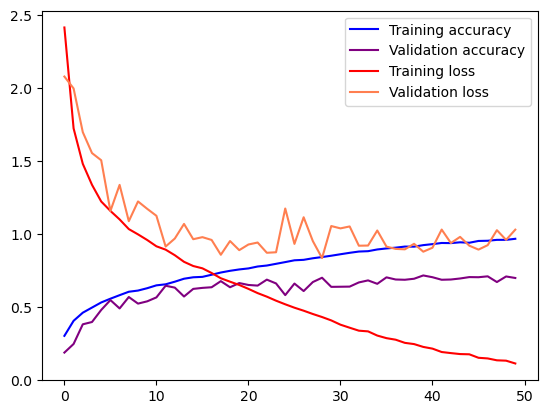

In [26]:
plt.plot(history.history['accuracy'], label='Training accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation accuracy', color='purple')
plt.plot(history.history['loss'], label='Training loss', color = 'red')
plt.plot(history.history['val_loss'], label='Validation loss', color='coral')
plt.legend()
plt.show()

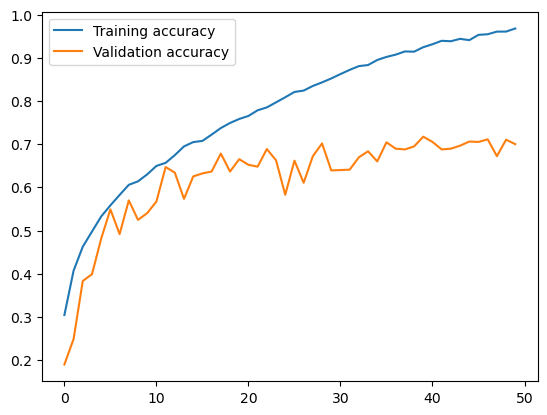

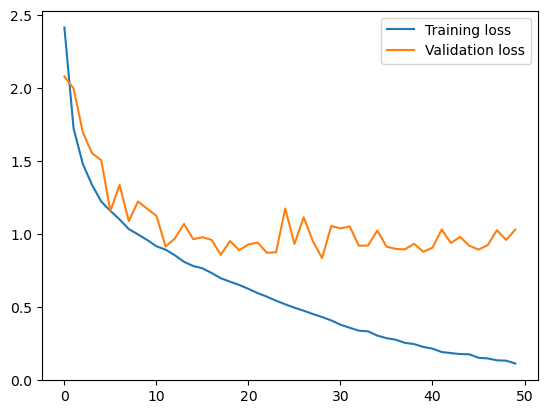

In [27]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

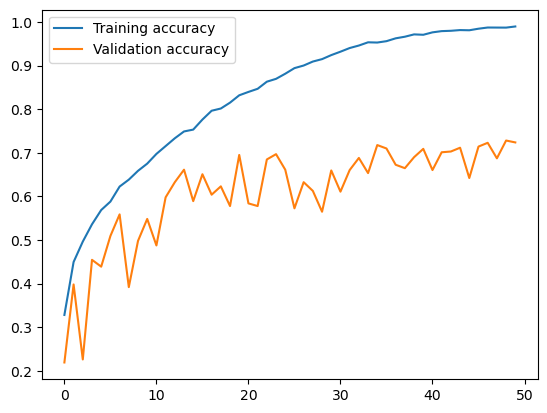

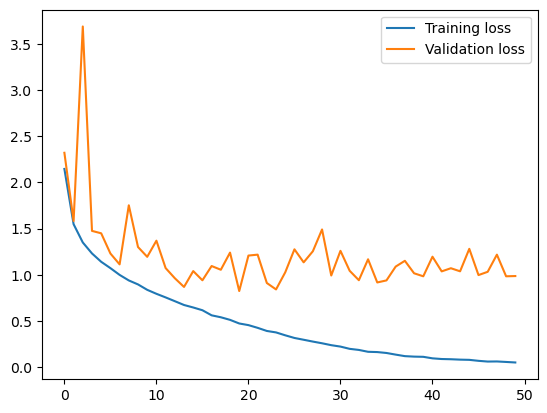

In [39]:
plt.plot(history.history['accuracy'], label='Training accuracy') #0.4 dropout
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [11]:
def get_svm_predictions(x_train_features, x_test_features, y_train, y_test):
    x_train_features  = x_train_features.reshape(x_train_features.shape[0], -1)
    x_test_features = x_test_features.reshape(x_test_features.shape[0], -1)

    clf = svm.SVC(kernel="rbf")
    clf.fit(x_train_features, np.argmax(y_train, axis=1))
    return clf.predict(x_test_features)

def plot_confusion_matrix(y_test, y_pred, cmap = plt.cm.Blues):
    ConfusionMatrixDisplay.from_predictions(y_pred=y_pred, y_true=np.argmax(y_test, axis=1), cmap=cmap)
    plt.xticks(np.arange(len(classes)), lesion_type_dict, rotation=45)
    plt.yticks(np.arange(len(classes)), lesion_type_dict)
    plt.grid(False)
    plt.show()
    
def plot_classification_report(y_test, y_pred, target_names):
    print(classification_report(y_pred=y_pred, y_true= np.argmax(y_test, axis=1), target_names=target_names))

def create_and_plot_confusion_matrix(y_test, y_pred):
    def plot_cm(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        #plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, lesion_type_dict, rotation=45)
        plt.yticks(tick_marks, lesion_type_dict)

        if normalize:
            cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals = 2)

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.grid(False)
        plt.show()
    cm = confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=y_pred)
    plot_cm(cm, normalize=False, classes = classes)
    
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

def print_multiclass_cm_metrics(y_test, y_pred, visualize = False, printable = True, plottable=True):
    mcm = multilabel_confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=y_pred)
    accuracy = []
    sensitivity = []
    specificity = []
    precision = []
    
    for i in range(len(mcm)):
        if printable:
            print(f'Current Label: {lesion_type_dict[lesion_tag_dict[i]]}')
        if visualize:
            print(mcm[i])
        tp = mcm[i][1,1]
        tn = mcm[i][0,0]
        fp = mcm[i][0,1]
        fn = mcm[i][1,0]
        
        current_accuracy = (tp+tn)/(tp+tn+fp+fn)
        current_sensitivity = (tp)/(tp+fn)
        current_specificity = (tn)/(tn+fp)
        current_precision = (tp)/(tp+fp)
        if printable:
            print(f"\tPrecision: {current_precision}")
            print(f"\tSensitivity: {current_sensitivity}")
            print(f"\tSpecificity: {current_specificity}")
            print(f"\tAccuracy: {current_accuracy}")
            print()
        accuracy.append(current_accuracy)
        precision.append(current_precision)
        sensitivity.append(current_sensitivity)
        specificity.append(current_specificity)
    
    width = 0.3
    x = np.arange(len(classes))
    font_size=6
    if plottable:
        plt.bar(x-width,precision, width = width, label='Precision')
        plt.bar(x, accuracy, width=width, label='Accuracy')
        plt.bar(x+width, sensitivity, width=width, label='Sensitivity')
        for x1, x2, x3, y1, y2, y3 in zip(x-width, x, x+width, precision, accuracy, sensitivity):
            plt.text(x1, y1, '%.2f' % y1, ha='center', va='bottom', fontsize=font_size)
            plt.text(x2, y2, '%.2f' % y2, ha='center', va='bottom', fontsize=font_size)
            plt.text(x3, y3, '%.2f' % y3, ha='center', va='bottom', fontsize=font_size)
        plt.xticks(x, lesion_type_dict)
        plt.legend(loc='lower left')
        plt.show()
def get_metrics(x, y):
    y_pred = model.predict(x)
    y_pred = np.argmax(y_pred, axis=1)
    plot_confusion_matrix(y_test=y, y_pred=y_pred)
    plot_classification_report(y_pred=y_pred, y_test=y, target_names=classes)
    print_multiclass_cm_metrics(y_test=y,y_pred=y_pred)

In [10]:
x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')

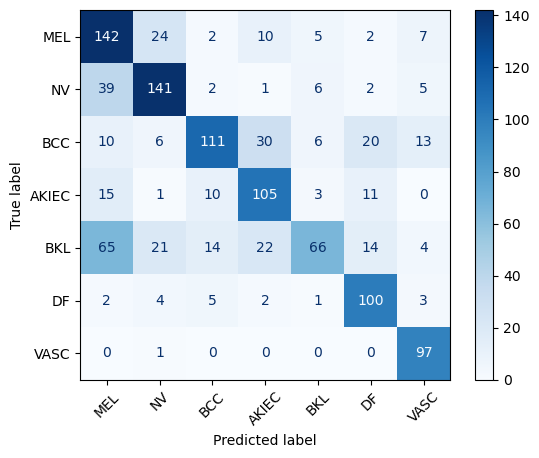

                      precision    recall  f1-score   support

            Melanoma       0.52      0.74      0.61       192
   Melanocytic nevus       0.71      0.72      0.72       196
Basal cell carcinoma       0.77      0.57      0.65       196
   Actinic keratoses       0.62      0.72      0.67       145
    Benign keratosis       0.76      0.32      0.45       206
      Dermatofibroma       0.67      0.85      0.75       117
     Vascular lesion       0.75      0.99      0.85        98

            accuracy                           0.66      1150
           macro avg       0.69      0.70      0.67      1150
        weighted avg       0.69      0.66      0.65      1150

Current Label: Melanoma
	Precision: 0.5201465201465202
	Sensitivity: 0.7395833333333334
	Specificity: 0.8632567849686847
	Accuracy: 0.8426086956521739

Current Label: Melanocytic nevus
	Precision: 0.7121212121212122
	Sensitivity: 0.7193877551020408
	Specificity: 0.940251572327044
	Accuracy: 0.9026086956521739

Cur

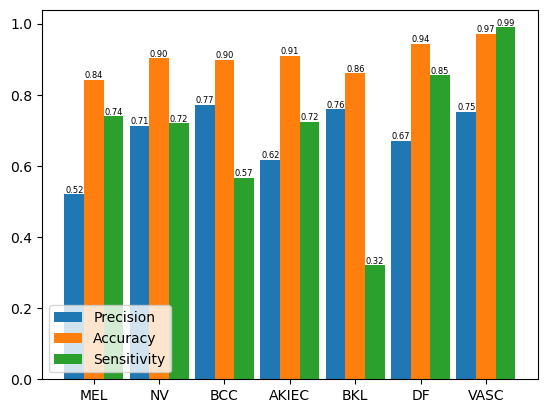

In [23]:
get_metrics(x_test, y_test) # 1000 dense

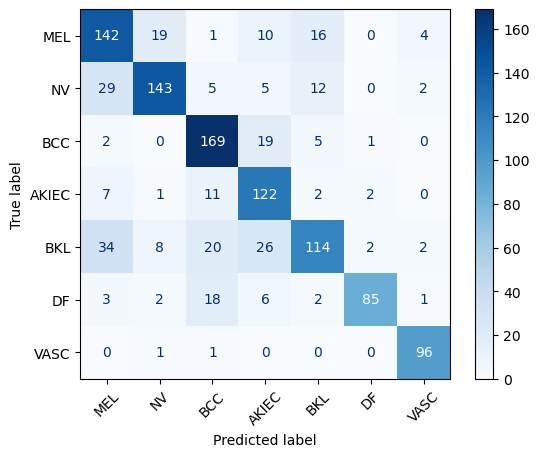

                      precision    recall  f1-score   support

            Melanoma       0.65      0.74      0.69       192
   Melanocytic nevus       0.82      0.73      0.77       196
Basal cell carcinoma       0.75      0.86      0.80       196
   Actinic keratoses       0.65      0.84      0.73       145
    Benign keratosis       0.75      0.55      0.64       206
      Dermatofibroma       0.94      0.73      0.82       117
     Vascular lesion       0.91      0.98      0.95        98

            accuracy                           0.76      1150
           macro avg       0.78      0.78      0.77      1150
        weighted avg       0.77      0.76      0.76      1150

Current Label: Melanoma
	Precision: 0.6543778801843319
	Sensitivity: 0.7395833333333334
	Specificity: 0.9217118997912317
	Accuracy: 0.8913043478260869

Current Label: Melanocytic nevus
	Precision: 0.8218390804597702
	Sensitivity: 0.7295918367346939
	Specificity: 0.9675052410901468
	Accuracy: 0.9269565217391305

Cu

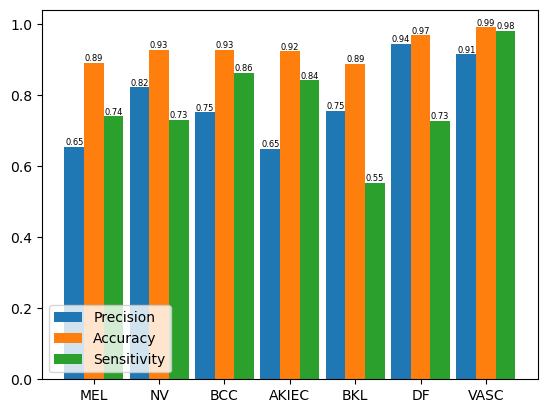

In [44]:
get_metrics(x_test, y_test) # 0.45 dropout

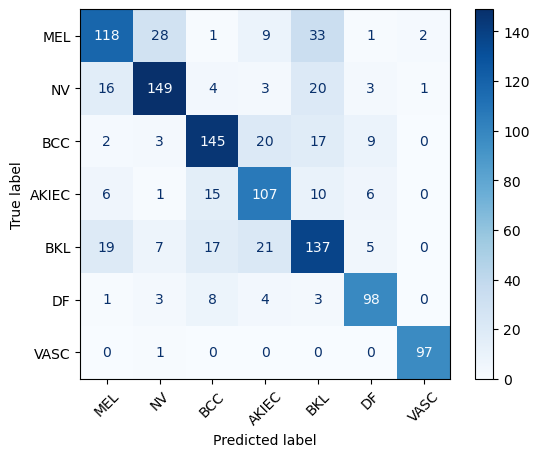

                      precision    recall  f1-score   support

            Melanoma       0.73      0.61      0.67       192
   Melanocytic nevus       0.78      0.76      0.77       196
Basal cell carcinoma       0.76      0.74      0.75       196
   Actinic keratoses       0.65      0.74      0.69       145
    Benign keratosis       0.62      0.67      0.64       206
      Dermatofibroma       0.80      0.84      0.82       117
     Vascular lesion       0.97      0.99      0.98        98

            accuracy                           0.74      1150
           macro avg       0.76      0.76      0.76      1150
        weighted avg       0.74      0.74      0.74      1150

Current Label: Melanoma
	Precision: 0.7283950617283951
	Sensitivity: 0.6145833333333334
	Specificity: 0.954070981210856
	Accuracy: 0.8973913043478261

Current Label: Melanocytic nevus
	Precision: 0.7760416666666666
	Sensitivity: 0.7602040816326531
	Specificity: 0.9549266247379455
	Accuracy: 0.9217391304347826

Cur

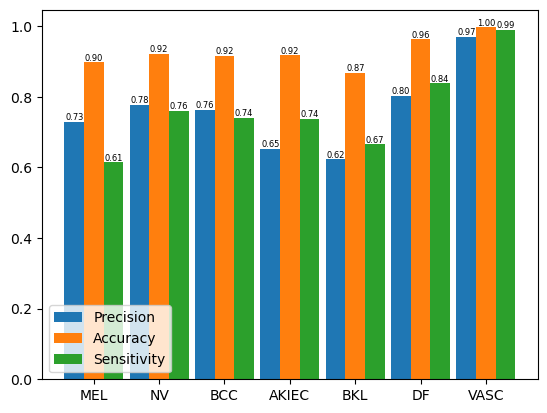

In [38]:
get_metrics(x_test, y_test) # 0.4 dropout

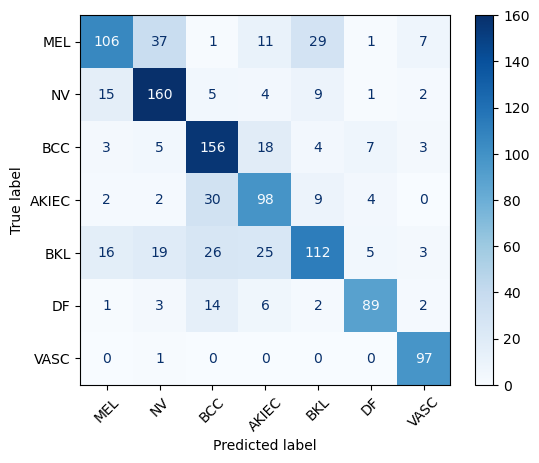

                      precision    recall  f1-score   support

            Melanoma       0.74      0.55      0.63       192
   Melanocytic nevus       0.70      0.82      0.76       196
Basal cell carcinoma       0.67      0.80      0.73       196
   Actinic keratoses       0.60      0.68      0.64       145
    Benign keratosis       0.68      0.54      0.60       206
      Dermatofibroma       0.83      0.76      0.79       117
     Vascular lesion       0.85      0.99      0.92        98

            accuracy                           0.71      1150
           macro avg       0.73      0.73      0.72      1150
        weighted avg       0.71      0.71      0.71      1150

Current Label: Melanoma
	Precision: 0.7412587412587412
	Sensitivity: 0.5520833333333334
	Specificity: 0.9613778705636743
	Accuracy: 0.8930434782608696

Current Label: Melanocytic nevus
	Precision: 0.7048458149779736
	Sensitivity: 0.8163265306122449
	Specificity: 0.929769392033543
	Accuracy: 0.9104347826086957

Cur

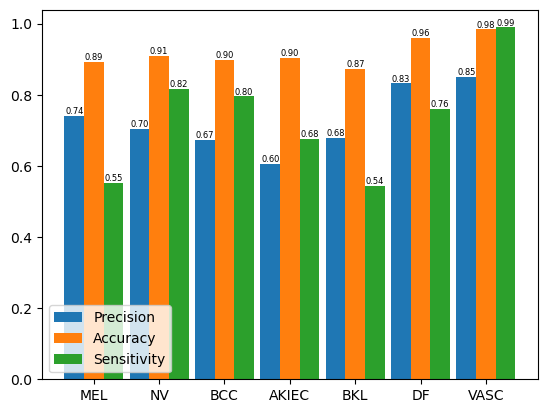

In [34]:
get_metrics(x_test, y_test) # 0.5 Dropout

In [45]:
model.save('model_augmentation_0_45.h5')